# Business Understanding

# Data Understanding

# Data Preperation

In [1]:
#!pip install opencv-python

In [40]:
# Importing the necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import imghdr
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
from glob import glob
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Directory containing the video files
video_directory = '/home/adam/Documents/Flatiron/Capstone/Tennis_Shot_Analysis/data/forehands/vids'

# Output directory for extracted frames
output_directory = '/home/adam/Documents/Flatiron/Capstone/Tennis_Shot_Analysis/data/forehands/frames'

# Function to extract frames from a video file
def extract_frames(video_file, output_dir):
    # Open the video file
    vid = cv2.VideoCapture(video_file)
    if not vid.isOpened():
        print(f"Error: Couldn't open video file '{video_file}'")
        return

    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Initialize frame counter
    current_frame = 0

    # Read frames and save them as images
    while True:
        success, frame = vid.read()

        if not success:
            print(f"End of video reached or couldn't read frame from '{video_file}'")
            break

        if frame.shape[0] > 0 and frame.shape[1] > 0:
            # Save the frame as an image
            output_path = os.path.join(output_dir, f'{os.path.splitext(os.path.basename(video_file))[0]}_{current_frame}.jpg')
            cv2.imwrite(output_path, frame)
            current_frame += 1
        else:
            print(f"Error: Invalid frame size in '{video_file}'")

    vid.release()

# Iterate over video files in the directory
for video_file in os.listdir(video_directory):
    if video_file.endswith('.mp4') or video_file.endswith('.avi'):
        video_path = os.path.join(video_directory, video_file)
        extract_frames(video_path, output_directory)

End of video reached or couldn't read frame from '/home/adam/Documents/Flatiron/Capstone/Tennis_Shot_Analysis/data/forehands/vids/adamforehand3.mp4'
End of video reached or couldn't read frame from '/home/adam/Documents/Flatiron/Capstone/Tennis_Shot_Analysis/data/forehands/vids/adamforehand4.mp4'
End of video reached or couldn't read frame from '/home/adam/Documents/Flatiron/Capstone/Tennis_Shot_Analysis/data/forehands/vids/adamforehand2.mp4'
End of video reached or couldn't read frame from '/home/adam/Documents/Flatiron/Capstone/Tennis_Shot_Analysis/data/forehands/vids/adamforehand1.mp4'


In [4]:
# Defining a data directory
data_dir = 'data'

In [5]:
# Defining image extensions
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [6]:
# Checking the contents of my data directory
os.listdir(data_dir)

['forehands', 'backhands']

In [7]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

Issue with image data/forehands/vids
Issue with image data/forehands/frames
Issue with image data/backhands/vids
Issue with image data/backhands/frames


In [8]:
tf.data.Dataset

tensorflow.python.data.ops.dataset_ops.DatasetV2

In [9]:
# you can change batch size here
data = tf.keras.preprocessing.image_dataset_from_directory('data')

Found 148 files belonging to 2 classes.


In [10]:
# allow acces to generator from the data pipeline
data_iterator = data.as_numpy_iterator()

In [11]:
# allow access to pull a batch of data
batch = data_iterator.next()

In [12]:
# Images represented as numpy arrays
batch[0].shape

(32, 256, 256, 3)

In [13]:
batch[1]

array([0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 1, 0, 1], dtype=int32)

Forehands = 1
Backhands = 0

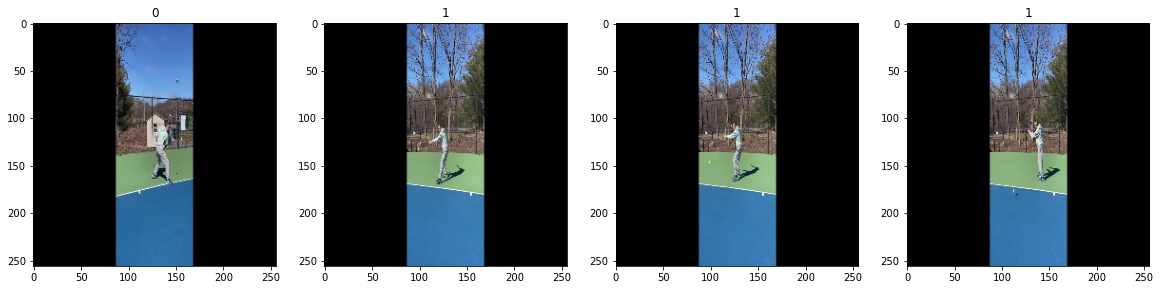

In [14]:
# viewing a batch of data to see what class my frames belong to
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [15]:
# scaling data
data = data.map(lambda X,y: (X/255, y))

In [16]:
scaled_iterator = data.as_numpy_iterator()

In [17]:
batch = scaled_iterator.next()

In [18]:
# confirming the min is 0
batch[0].min()

0.0

In [19]:
# confirming max is 1
batch[0].max()

1.0

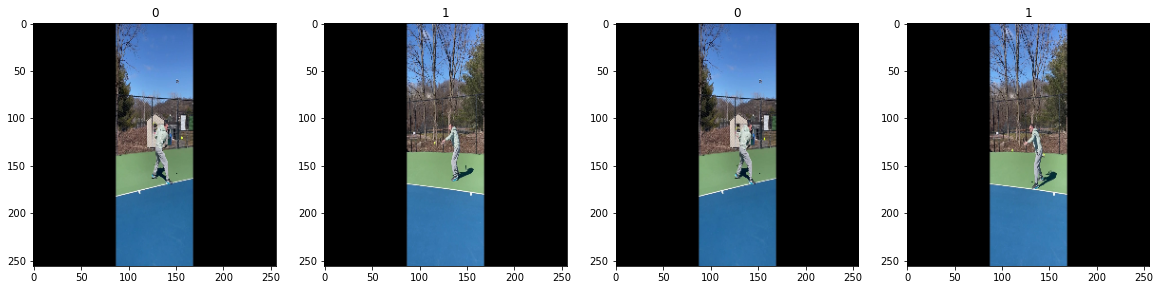

In [20]:
# viewing a batch of data to see what class my frames belong to
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

In [21]:
# There are 5 batches - currently set to 32 in a batch
len(data)

5

In [22]:
# Splitting data into 80% training, 20% testing
train_size = int(len(data)*.8)
test_size = int(len(data)*.2)

In [23]:
#### Insert a validation size on the main model

In [24]:
train = data.take(train_size)
test = data.skip(train_size).take(test_size)

# Modeling

In [25]:
model = Sequential()

In [26]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [27]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 16)        4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 14400)             0

In [29]:
logdir = 'logs'

In [30]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [37]:
hist = model.fit(train, epochs=20, validation_data=test, callbacks=[tensorboard_callback])

Epoch 1/20
1/4 [======>.......................] - ETA: 0s - loss: 0.6982 - accuracy: 0.4688WARNING:tensorflow:From /home/adam/anaconda3/envs/learn-env-1/lib/python3.8/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
4/4 [==============================] - 2s 376ms/step - loss: 0.5040 - accuracy: 0.6875 - val_loss: 0.2892 - val_accuracy: 1.0000
Epoch 2/20
4/4 [==============================] - 2s 384ms/step - loss: 0.1461 - accuracy: 1.0000 - val_loss: 0.0372 - val_accuracy: 1.0000
Epoch 3/20
4/4 [==============================] - 1s 357ms/step - loss: 0.0195 - accuracy: 1.0000 - val_loss: 0.0072 - val_accuracy: 1.0000
Epoch 4/20
4/4 [==============================] - 1s 368ms/step - loss: 0.0056 - accuracy: 1.0000 - val_loss: 8.7546e-04 - val_accuracy: 1.0000
Epoch 5/20
4/4 [==============================] - 1

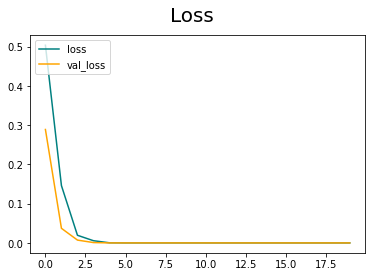

In [38]:
# Visualizing our loss
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

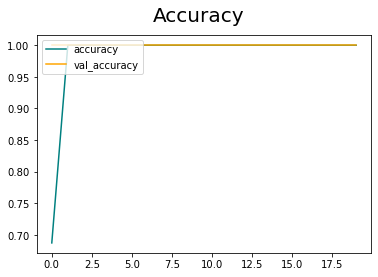

In [39]:
# Visualizing our accuracy
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [41]:
precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()

In [42]:
for batch in test.as_numpy_iterator():
    X, y = batch
    y_hat = model.predict(X)
    precision.update_state(y, y_hat)
    recall.update_state(y, y_hat)
    accuracy.update_state(y, y_hat)

In [43]:
print(f'Precision:{precision.result().numpy()}, Recall:{recall.result().numpy()}, Accuracy:{accuracy.result().numpy()})

SyntaxError: EOL while scanning string literal (<ipython-input-43-f8cfbd5f64fe>, line 1)

# Conclusions

## Limitations

## Recommendations

## Next Steps